# Tutorial

## Introduction

This is a short tutorial which demonstrates the functionality of ThermoPot (v1.1.0-beta.1). This considers reactions for the Ba-Zr-S system. 

We will use ThermoPot to calculate the change in Gibbs free energy for a reaction, at a range of temperature and pressures. We
will identify at which temperatures and pressures (if any) the
perovskite BaZrS$_3$ decomposes into it's competing binary phases, BaS and ZrS2.

To do these calculations we need the total ground-state energy of each
material, calculated using DFT or elsewise. For predictions at finite
temperature and pressure we need, in addition, vibrational data for each
material. For solid materials this can also be calculated from
first-principles using lattice dynamics. 

For gaseous compounds experimental data can be used. For Sulfur there is, in addition, a parameterised mathematical which is valid between 100-1400K and 1-10$^7$Pa. Vapours are not explored in this tutorial, but there are several examples in a notebook in [this repository](https://github.com/NU-CEM/2023_BaZrS3_Thermodynamic_Model/).

## Code structure

There are three core classes in ThermoPot:

1) Calculation to store data for a
single calculation. For example, an energy calculated using the HSE06 functional

2) Material to store data and make predictions for a single material. For
example BaZrS$_3$, with energies calculated at
various levels of theory.

3) Reaction to store data  and make predictions for a single chemical
reaction. For example BaZrS$_3$ -> BaS$_2$ + ZrS

The structure is hierachial; one or more `Calculation` instances are used to
build a `Material` instance, and one or more `Material` objects are used to
calculate a `Reaction` instance. In addition to this there are is the
`Potential` class to store and plot a single thermodynamic potential, and
the `Potentials` class to store and plot multiple thermodynamic potentials.



## Step 1 - import relevant libraries

In [21]:
import numpy as np
from thermopot import calculations, materials, reactions, potentials

## Step 2 - create `calculations`

There are two ways to create a `Calculations` object:
1) Manually input the attributes (calculated energy, xc-functional type,
   volume, number of atoms). 
   
2) Parse a FHI-aims output file to read this data
   automatically. Provide the path for an `aims.out` file. 

We will provide an example for each which uses the `vars`
function to show that the class attributes are equal.

In [3]:
# Method 1

BaS_calc = calculations.Calculation(volume=63.2552,energy=-235926.586148547,
                            xc='pbesol',
                            NAtoms=2)
vars(BaS_calc)

{'volume': 63.2552,
 'filepath': None,
 'energy': -235926.586148547,
 'xc': 'pbesol',
 'NAtoms': 2}

In [4]:
# Method 2

BaS_calc = calculations.AimsCalculation("./data/BaS/aims.out")
vars(BaS_calc)

{'volume': 63.2552,
 'filepath': './docs/data/BaS/aims.out',
 'energy': -235926.58614863,
 'xc': 'pbesol',
 'NAtoms': 2}

For in-notebook help with functions, docstrings can be accessed with a `?` to trigger the docstring for the class. Alternatively, a Python `help()` function can be used. Feel free to use this for any object to fimilarise yourself with the internal workings of the code.  

In [5]:
calculations.AimsCalculation?
help(calculations.AimsCalculation)

Help on class AimsCalculation in module thermopot.calculations:

class AimsCalculation(Calculation)
 |  AimsCalculation(filepath='./calculation.out', gas=False)
 |  
 |  Class for parsing and storing data from a FHI-AIMS total energy calculation.
 |  
 |  Example:
 |  
 |     BaS_calc = AimsCalculation("./aims_output/output.aims")
 |  
 |  Attributes:
 |  
 |      volume (float): volume of the periodic unit cell in Angstrom^3
 |      filepath (str): path to the calculation output files
 |      energy (float): DFT total energy in eV
 |      xc (str): XC functional used to calculate the total energy
 |      NAtoms (int): number of atoms in the periodic unit cell
 |  
 |  Method resolution order:
 |      AimsCalculation
 |      Calculation
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filepath='./calculation.out', gas=False)
 |      Args:
 |      
 |          filepath (str): path to the calculation output files
 |          gas (bool): True if gas species, 

We will now read in the calculations for the other compounds.

In [6]:
BaZrS3_calc = calculations.AimsCalculation("./data/BaZrS3/aims.out")
ZrS2_calc =  calculations.AimsCalculation("./data/ZrS2/aims.out")

## Step 3 - create `materials`

The attributes (name, stoichiometry, filepath of ) of a `materials.Solid` has to be stored in a variable. 

In [26]:
BaZrS3 = materials.Solid('BaZrS3',{"Ba":1,"Zr":1,"S":3},"./data/BaZrS3/BaZrS3_Pnma.dat", BaZrS3_calc)

BaS = materials.Solid('BaS',{"Ba":1,"S":1},"./data/BaS/BaS_Fm-3m.dat", BaS_calc)

ZrS2 = materials.Solid('ZrS2',{"Zr":1,"S":2},"./data/ZrS2/ZrS2_P-3m1.dat", ZrS2_calc)

In [27]:
vars(BaZrS3)

{'name': 'BaZrS3',
 'stoichiometry': {'Ba': 1, 'Zr': 1, 'S': 3},
 'energies': {'pbesol': -1425527.242293353},
 'N': 5,
 'volume': 484.624,
 'NAtoms': 20,
 'fu_cell': 4.0,
 'phonon_filepath': '/Users/mynf8/Repos/ThermoPot/./docs/data/BaZrS3/BaZrS3_Pnma.dat'}

In addition, each materials has a number of thermodynamic properties (gibbs, helmholtz, internal, heat capacity)  which can be calculated using the associated method. For example, the gibbs free energy of BaZrS3 at room temperature and one bar is:

In [28]:
BaZrS3.mu(T=273,P=1E5,units='eV')

-356381.89093748876

## Step 4 - define a `reaction`

We model the combination or decomposition of `materials` with the `reaction` class where the formula unit of reactants and products are specified so as to maintain mass balance. 

In [29]:
perovskite_degradation = reactions.Reaction({BaZrS3:1}, {BaS:1,ZrS2:1})

In [30]:
vars(perovskite_degradation)

{'reactants': {<thermopot.materials.Solid at 0x7fc22ab779a0>: 1},
 'products': {<thermopot.materials.Solid at 0x7fc22ab767a0>: 1,
  <thermopot.materials.Solid at 0x7fc22ab757e0>: 1},
 'T': 298.15,
 'P': 100000.0,
 'fu_scaling': 1}

## Step 5 - calculate the `potential`

The first thing we do is decide what temperature range and pressure range we are interested in. Note that the pressure array is transposed to allow for numpy broadcasting.

In [31]:
T = np.linspace(100, 1000, 100)
P = np.array(np.logspace(1, 7, 100), ndmin=2).transpose()

We can now calculate a range of thermodynamic potentials (gibbs, helmholtz, internal, ground-state) which are accessed from a `reaction` instance. For example, the Gibbs free energy of degradation is:

In [34]:
gibbs = perovskite_degradation.Dmu(T,P)
gibbs.potential

array([[0.48560878, 0.48627862, 0.48697174, ..., 0.56222696, 0.56302549,
        0.56382403],
       [0.48560878, 0.48627862, 0.48697174, ..., 0.56222696, 0.56302549,
        0.56382403],
       [0.48560878, 0.48627862, 0.48697174, ..., 0.56222696, 0.56302549,
        0.56382403],
       ...,
       [0.48560878, 0.48627862, 0.48697174, ..., 0.56222696, 0.56302549,
        0.56382403],
       [0.48560878, 0.48627862, 0.48697174, ..., 0.56222696, 0.56302549,
        0.56382403],
       [0.48560878, 0.48627862, 0.48697174, ..., 0.56222696, 0.56302549,
        0.56382403]])

`gibbs` is an instance of the `potential` class, which has a number of methods and instance variables associated with it.

## Step 6 - visualise your `potential`

A simple contour plot of `potential` across the temperature and pressure variables specified can be generated.

<module 'matplotlib.pyplot' from '/Users/mynf8/miniconda3/lib/python3.10/site-packages/matplotlib/pyplot.py'>

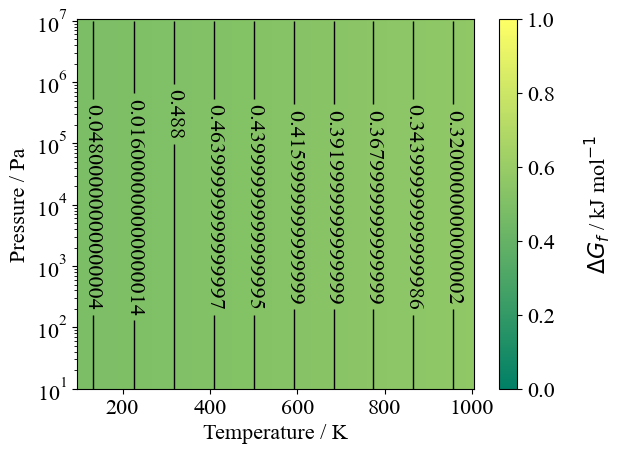

In [44]:
gibbs.plot_TvsP(precision=2,scale_range=[0,1])

Note that `plot_TvsP()` returns a `matplotlib.pyplot.plt` object so that it easy to adjust the plot.

(400.0, 800.0)

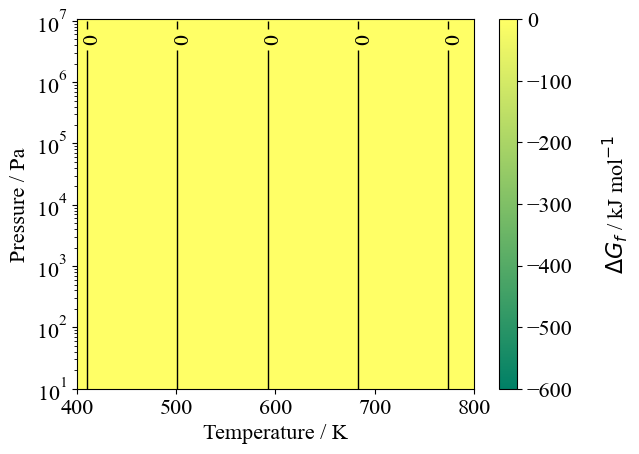

In [52]:
plt = gibbs.plot_TvsP()
plt.yscale('log')
plt.xlim([400,800])